In [1]:
import pandas as pd
import numpy as np
import json

import scipy.stats as stats
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Start analyses

In [2]:
iti=0
countdown=0

min_rt=300
max_rt=2500

In [3]:
actual_data=np.load('data_files/trialdata_spatial_dict.npy',allow_pickle=True)

In [4]:
subject_data_dict=dict()
for sub in np.unique(actual_data[:,0]):
    sub_trials=actual_data[actual_data[:,0]==sub,3]
    
    conf_vals=[]
    for trial in sub_trials:
        if 'TrialName' in trial:
            conf_vals.append(int(trial['Confidence']))
        else:
            conf_vals.append(np.nan)
    
    zscore_conf=(conf_vals-np.nanmean(conf_vals))/np.nanstd(conf_vals)

    for t, trial in enumerate(sub_trials):
        if 'TrialName' in trial:
            trial['Zscore_Conf']=zscore_conf[t]                     
           
    actual_data[actual_data[:,0]==sub,3]=sub_trials
    
    subject_data_dict[sub]=[x for x in sub_trials if 'TrialName' in x]

In [5]:
# Figure out how many in each group 
group1=[sub for sub in subject_data_dict.keys() if 'occlusion_collision_topple_T1.mp4'
 in [i['TrialName'] for i in subject_data_dict[sub]]]
print(len(group1))

group2=[sub for sub in subject_data_dict.keys() if 'occlusion_collision_topple_C1.mp4'
 in [i['TrialName'] for i in subject_data_dict[sub]]]
print(len(group2))

15
13


In [6]:
names=[i['TrialName'] for i in subject_data_dict[group1[0]]]

num_target=0
num_control=0
num_no=0
for name in names:
    if name[-6:-5]=='T': # if its a probe trial 
        num_target+=1
    elif name[-6:-5]=='C':
        num_control+=1
    else:
        num_no+=1
        
print('Target: %d, Control: %d, No probe: %d' %(num_target, num_control, num_no))

Target: 26, Control: 32, No probe: 6


In [7]:
names=[i['TrialName'] for i in subject_data_dict[group1[0]]]

num_target=0
num_control=0
num_no=0
for name in names:
    if name[-6:-5]=='T': # if its a probe trial 
        num_target+=1
    elif name[-6:-5]=='C':
        num_control+=1
    else:
        num_no+=1
        
print('Target: %d, Control: %d, No probe: %d' %(num_target, num_control, num_no))

Target: 26, Control: 32, No probe: 6


In [8]:
real_trials=[x for x in actual_data[:,3] if 'TrialName' in x]
print(len(real_trials))

1792


In [9]:
key_mapping=pd.read_csv('exp4_video_key_mapping.csv',delimiter=',')
key_mapping.head()

,video_name,probe_type,Time_1,Event_1,Coords_A1,Coords_T1,Coords_C1,Time_2,Event_2,Coords_A2,Coords_T2,Coords_C2,Time_3,Event_3,Coords_A3,Coords_T3,Coords_C3
0,collision_collision_containment,E_Key,1:18,1:27,"1170, 875","710, 875","650, 960",3:01,3:27,"800, 875","535, 875","470, 915",NaN,NaN,NaN,NaN,NaN
1,collision_collision_occlusion,F_Key,2:12,2:27,"930, 860","735, 860","775, 965",4:09,5:17,"575, 860","410, 890","365, 1000",NaN,NaN,NaN,NaN,NaN
2,collision_falling_occlusion,E_Key,0:25,1:00,"1650, 250","1550, 255","1515, 510",2:05,2:20,"505, 855","295, 900","290, 1000",NaN,NaN,NaN,NaN,NaN
3,collision_occlusion_collision,F_Key,1:07,1:29,"1120, 850","900, 870","890, 950",3:00,3:17,"540, 850","320, 850","230, 930",NaN,NaN,NaN,NaN,NaN
4,collision_occlusion_containment,E_Key,1:08,1:29,"1400, 860","1235, 860","1235, 980",2:29,3:27,"870, 840","625, 840","515, 980",NaN,NaN,NaN,NaN,NaN


In [10]:
names=[i['TrialName'] for i in subject_data_dict[group2[0]]]

keys=[]
for name in names:
    
    
    if name[-6:-5]=='T': # if its a probe trial 
        video=name.split('_T')[0]
    elif name[-6:-5]=='C':
        video=name.split('_C')[0]
    else:
        video=name.split('.mp4')[0]
        
    keys.append(key_mapping.probe_type[np.where(key_mapping.video_name==video)[0][0]])
e=sum(np.array(keys)=='E_Key')
f=sum(np.array(keys)=='F_Key')
print(e,f)

32 32


In [11]:
remove_extra=1
restrict_rt=1

extra_keys=[]
extra_keys_wrong=[]
outofrange_rt=[]

reorganized_data_dict=dict()

for sub in subject_data_dict.keys():
    # preset
    reorganized_data_dict[sub]=dict()
    reorganized_data_dict[sub]['names']=[]
    reorganized_data_dict[sub]['probe']=[]
    reorganized_data_dict[sub]['keypresses']=[]
    reorganized_data_dict[sub]['key_type']=[]
    reorganized_data_dict[sub]['wrong_keypresses']=[]
    reorganized_data_dict[sub]['confidence']=[]
    reorganized_data_dict[sub]['confidence_z']=[]
    reorganized_data_dict[sub]['rt_correct']=[]
    reorganized_data_dict[sub]['rt_wrong']=[]
    
    real_trials=subject_data_dict[sub]
    
    subject_exclude_counter=0

    for trial in real_trials:

        ignore_trial=False # preset

        probe_num=trial['TrialName'].split('_')[-1].split('.')[0]

        # Was this a probe or not?
        if probe_num=='T1' or probe_num=='T2' or probe_num=='T3':
            probe_type=1 # target probe
            end_tag='_'+probe_num # reset
            temp_key='Time_%s' % probe_num[1]
        elif probe_num=='C1' or probe_num=='C2' or probe_num=='C3':
            probe_type=2 # control probe
            end_tag='_'+probe_num # reset
            temp_key='Time_%s' % probe_num[1]
        else:
            temp_key='Time_1' # just make it the first one but it doesn't matter
            probe_type=0 # no probe
            end_tag='.mp4' # reset
            
        # what is the key press we are looking for?
        video_name=trial['TrialName'].split(end_tag)[0]
        key_type=np.array(key_mapping[key_mapping.video_name==video_name].probe_type)[0]

        # what's the wrong key then? 
        if key_type=='E_Key':
            wrong_key='F_Key'
        elif key_type=='F_Key':
            wrong_key='E_Key'

        if len(trial[key_type])==0:
            correct_key_timing=np.nan
            rt_val_correct=np.nan

        elif len(trial[key_type])>1:

            # do you want to remove the trials when the pressed the space bar multiple times? or just the first spacebar?
            if remove_extra==1: 
                rt_val_correct=np.nan
                ignore_trial=True
                subject_exclude_counter+=1

            else: 
                correct_key_timing=trial[key_type][0]

                probe_time=float(key_mapping[temp_key][np.where(key_mapping.video_name==video_name)[0][0]].replace(':','.'))*1000
                rt_val_correct=correct_key_timing-probe_time  

            extra_keys.append(trial[key_type])

        else:
            correct_key_timing=trial[key_type][0]
            probe_time=float(key_mapping[temp_key][np.where(key_mapping.video_name==video_name)[0][0]].replace(':','.'))*1000
            rt_val_correct=correct_key_timing-probe_time  

        if len(trial[wrong_key])==0:
            wrong_key_timing=np.nan
            rt_val_wrong=np.nan

        elif len(trial[wrong_key])>1:

            # do you want to remove the trials when the pressed the space bar multiple times? or just the first spacebar?
            if remove_extra==1: 
                rt_val_wrong=np.nan

            else: 
                wrong_key_timing=trial[wrong_key][0]
                probe_time=float(key_mapping[temp_key][np.where(key_mapping.video_name==video_name)[0][0]].replace(':','.'))*1000
                rt_val_wrong=wrong_key_timing-probe_time  

            extra_keys_wrong.append(trial[wrong_key])

        else:
            wrong_key_timing=trial[wrong_key][0]
            probe_time=float(key_mapping[temp_key][np.where(key_mapping.video_name==video_name)[0][0]].replace(':','.'))*1000
            rt_val_wrong=wrong_key_timing-probe_time  


        # also ignore trial if they pressed both keys
        if len(trial[key_type])>=1 and len(trial[wrong_key])>=1:
            ignore_trial=True
            subject_exclude_counter+=1
            wrong_key_timing=np.nan
            correct_key_timing=np.nan
            rt_val_wrong=np.nan
            rt_val_correct=np.nan

            
        # remember the trials with out of range RTs
        if rt_val_correct > max_rt or rt_val_correct < min_rt:

            outofrange_rt.append(rt_val_correct)

            if restrict_rt==1:
                ignore_trial=True
                subject_exclude_counter+=1

        # only save if the trial isn't bein excluded for some reason
        if ignore_trial==False:
            reorganized_data_dict[sub]['names']+=[trial['TrialName']]
            reorganized_data_dict[sub]['probe']+=[probe_type]
            reorganized_data_dict[sub]['keypresses']+=[correct_key_timing]
            reorganized_data_dict[sub]['wrong_keypresses']+=[wrong_key_timing]
            reorganized_data_dict[sub]['confidence']+=[trial['Confidence']]
            reorganized_data_dict[sub]['confidence_z']+=[trial['Zscore_Conf']]
            reorganized_data_dict[sub]['rt_correct']+=[rt_val_correct]
            reorganized_data_dict[sub]['rt_wrong']+=[rt_val_wrong]
            
            # but only save the key type if we did show a probe
            if probe_type==0:
                reorganized_data_dict[sub]['key_type']+=['none']
            else:
                reorganized_data_dict[sub]['key_type']+=[key_type]

    if subject_exclude_counter >= 32: 
        print('excluding participant %s (%d trials ignored)' %(sub,subject_exclude_counter))
        reorganized_data_dict.pop(sub)

### Probe detection

In [12]:
all_probes_target=[]
all_probes_control=[]

num_target=[]
num_control=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_target=[]
    probes_control=[]
    no_probes=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
            probes_target.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))
        elif reorganized_data_dict[sub]['probe'][i]==2:
            probes_control.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))
        else:
            no_probes.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))

    print(sub,len(probes_target),len(probes_control), len(no_probes))
    num_target.append(len(probes_target))
    num_control.append(len(probes_control))
    
    all_probes_target.append(np.nansum(probes_target)/len(probes_target))
    all_probes_control.append(np.nansum(probes_control)/len(probes_control))


debug0iCMg:debugWY61I 23 31 4
debugBEZtm:debugyuUEV 31 25 6
debugDHa10:debugW00CK 25 29 6
debugEKZo6:debugTZHgd 24 29 6
debugF0Ygs:debugkaQeS 27 24 5
debugGllfh:debug0IrHv 25 32 6
debugJ5iCd:debugfh5y4 31 24 5
debugMh0LT:debugcxEIB 24 27 6
debugOMHPx:debugk4Hmz 26 32 6
debugR7K73:debughs4QH 25 32 6
debugSpTtY:debugElPAb 30 25 5
debugT1mQA:debugSWcXn 32 24 6
debugULpzm:debugiI7NU 32 26 6
debugYi1CF:debugl3qvU 24 31 6
debuga5s3v:debugMahYT 24 26 6
debughcTSC:debugGNUKv 32 24 6
debugkIJMc:debugQSmRA 23 31 6
debugl1ZJT:debugcAxEj 25 29 6
debuglOKep:debugscIb2 30 23 6
debuglYWls:debug9gLtL 24 27 6
debugmYRmd:debugoGlaW 31 24 6
debugohwY9:debugGYEP1 30 23 6
debugpg6Ov:debugVP4xk 24 28 5
debugtV1Vf:debuggjVYU 24 32 6
debugv0eK8:debugHQjFF 29 25 6
debugw1cvt:debuggVhaX 26 31 6
debugxrt6i:debugZWrJP 30 26 6
debugyWHpH:debugLKCkP 22 18 5


In [13]:
print('Average target detected: = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_target),
                                                             np.nanmean(num_target)))
print('Average control detected: = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_control),
                                                                    np.nanmean(num_control)))

Average target detected: = 0.4931 (N=26.89 average)
Average control detected: = 0.4171 (N=27.07 average)


In [14]:
len(all_probes_target)

28

Ttest_relResult(statistic=3.542324452104427, pvalue=0.00146480643726191)


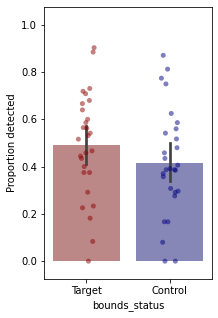

In [15]:
fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_target,all_probes_control)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_target)),
                                                          np.ones(len(all_probes_control))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
plt.xticks([0,1],['Target','Control'])
plt.ylabel('Proportion detected')
plt.ylim(-0.075,1.075)
print(stats.ttest_rel(all_probes_target,all_probes_control,nan_policy='omit'))

fig.savefig('svgs/exp2_spatialprobe/subjectwise_boundary_detection.svg')


In [16]:
# Calculate the Cohen's D 
difference = np.array(all_probes_target) - np.array(all_probes_control)
mean_diff = np.nanmean(difference)
sd_diff = np.nanstd(difference)

d = mean_diff/sd_diff
d

0.6817206586598282

23


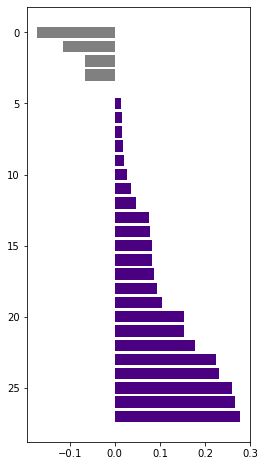

In [33]:
sub_differences=np.array(all_probes_target)-np.array(all_probes_control)

neg_vals=np.where(np.sort(sub_differences)<=0)[0]
pos_vals=np.where(np.sort(sub_differences)>0)[0]
colors=np.hstack((np.repeat('grey',len(neg_vals)),np.repeat('indigo',len(pos_vals))))

print(len(pos_vals))
fig,ax=plt.subplots(1,figsize=(4,8))
ax.barh(np.arange(len(sub_differences)),np.sort(sub_differences),color=colors)
ax.invert_yaxis()
fig.savefig('svgs/exp2_spatialprobe/subjectwise_target_detection_differences.svg')

### Controlling for distance to the agent 

In [18]:
all_probes_target=[]
all_probes_control=[]

num_target=[]
num_control=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_target=[]
    probes_control=[]
    probes_non_boundaries=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
            probes_target.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))
        elif reorganized_data_dict[sub]['probe'][i]==2:
            probes_control.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))

    print(sub,len(probes_target),len(probes_control))
    num_target.append(len(probes_target))
    num_control.append(len(probes_control))
    
    all_probes_target.append(np.nansum(probes_target)/len(probes_target))
    all_probes_control.append(np.nansum(probes_control)/len(probes_control))


debug0iCMg:debugWY61I 23 31
debugBEZtm:debugyuUEV 31 25
debugDHa10:debugW00CK 25 29
debugEKZo6:debugTZHgd 24 29
debugF0Ygs:debugkaQeS 27 24
debugGllfh:debug0IrHv 25 32
debugJ5iCd:debugfh5y4 31 24
debugMh0LT:debugcxEIB 24 27
debugOMHPx:debugk4Hmz 26 32
debugR7K73:debughs4QH 25 32
debugSpTtY:debugElPAb 30 25
debugT1mQA:debugSWcXn 32 24
debugULpzm:debugiI7NU 32 26
debugYi1CF:debugl3qvU 24 31
debuga5s3v:debugMahYT 24 26
debughcTSC:debugGNUKv 32 24
debugkIJMc:debugQSmRA 23 31
debugl1ZJT:debugcAxEj 25 29
debuglOKep:debugscIb2 30 23
debuglYWls:debug9gLtL 24 27
debugmYRmd:debugoGlaW 31 24
debugohwY9:debugGYEP1 30 23
debugpg6Ov:debugVP4xk 24 28
debugtV1Vf:debuggjVYU 24 32
debugv0eK8:debugHQjFF 29 25
debugw1cvt:debuggVhaX 26 31
debugxrt6i:debugZWrJP 30 26
debugyWHpH:debugLKCkP 22 18


In [19]:
key_mapping.head()

,video_name,probe_type,Time_1,Event_1,Coords_A1,Coords_T1,Coords_C1,Time_2,Event_2,Coords_A2,Coords_T2,Coords_C2,Time_3,Event_3,Coords_A3,Coords_T3,Coords_C3
0,collision_collision_containment,E_Key,1:18,1:27,"1170, 875","710, 875","650, 960",3:01,3:27,"800, 875","535, 875","470, 915",NaN,NaN,NaN,NaN,NaN
1,collision_collision_occlusion,F_Key,2:12,2:27,"930, 860","735, 860","775, 965",4:09,5:17,"575, 860","410, 890","365, 1000",NaN,NaN,NaN,NaN,NaN
2,collision_falling_occlusion,E_Key,0:25,1:00,"1650, 250","1550, 255","1515, 510",2:05,2:20,"505, 855","295, 900","290, 1000",NaN,NaN,NaN,NaN,NaN
3,collision_occlusion_collision,F_Key,1:07,1:29,"1120, 850","900, 870","890, 950",3:00,3:17,"540, 850","320, 850","230, 930",NaN,NaN,NaN,NaN,NaN
4,collision_occlusion_containment,E_Key,1:08,1:29,"1400, 860","1235, 860","1235, 980",2:29,3:27,"870, 840","625, 840","515, 980",NaN,NaN,NaN,NaN,NaN


In [20]:
distance_dict=dict()
temp_dict=dict()
temp_past_dict=dict()
for v, vid in enumerate(key_mapping.video_name):
    
    for val in range(1,4):
        
        if type(key_mapping['Coords_A%d' % val][v])==str:
            coords_a=np.array(key_mapping['Coords_A%d' % val][v].split(','),dtype='int')
            coords_t=np.array(key_mapping['Coords_T%d' % val][v].split(','),dtype='int')
            coords_c=np.array(key_mapping['Coords_C%d' % val][v].split(','),dtype='int')

            target_dist=distance.euclidean(coords_a,coords_t)
            control_dist=distance.euclidean(coords_a,coords_c)
            
            distance_dict[vid+'_T'+str(val)]=target_dist
            distance_dict[vid+'_C'+str(val)]=control_dist
            
            ms_event=float(key_mapping['Event_%d' % val][v].replace(':','.')) 
            ms_probe=float(key_mapping['Time_%d' % val][v].replace(':','.'))
            temp_dict[vid+'_T'+str(val)]=ms_event-ms_probe
            temp_dict[vid+'_C'+str(val)]=ms_event-ms_probe
            
            if val==1:
                ms_past_event=0
            else:
                ms_past_event=float(key_mapping['Event_%d' % (val-1)][v].replace(':','.')) 
           
            temp_past_dict[vid+'_T'+str(val)]=ms_probe-ms_past_event
            temp_past_dict[vid+'_C'+str(val)]=ms_probe-ms_past_event

In [21]:
probe_detection_vals=dict()

for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    for i, probe in enumerate(probe_names):

        if probe in probe_detection_vals.keys():
            probe_detection_vals[probe]+=[~np.isnan(reorganized_data_dict[sub]['keypresses'][i])]
        else:
            probe_detection_vals[probe]=[~np.isnan(reorganized_data_dict[sub]['keypresses'][i])]

In [22]:
distances=[]
movie_type=[]

for name in probe_detection_vals.keys():
    prefix=name.split('.mp4')[0]
    
    if prefix in distance_dict.keys():
        distances.append(distance_dict[prefix])
     
    if prefix[-2:-1] =='C':
        movie_type.append(2)
    elif prefix[-2:-1] =='T':
        movie_type.append(1)

distances=np.array(distances)
movie_type=np.array(movie_type)

Target probe trials: N = 58; Mean Distance= 219.95
Control probe trials: N = 58; Mean Distance= 286.97
Ttest_indResult(statistic=-5.609159852171034, pvalue=1.44242939923474e-07)


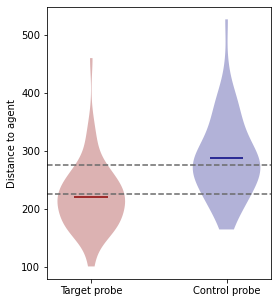

In [23]:
fig=plt.figure(figsize=(4,5))

v=plt.violinplot(np.array(distances)[movie_type==1],positions=[0],showextrema=False,showmeans=True)
for pc in v['bodies']:
    pc.set_facecolor('darkred')
v['cmeans'].set_edgecolor('darkred')
v=plt.violinplot(np.array(distances)[movie_type==2],positions=[1],showextrema=False,showmeans=True)
for pc in v['bodies']:
    pc.set_facecolor('navy')
v['cmeans'].set_edgecolor('navy')

plt.xticks([0,1],['Target probe','Control probe'])
plt.ylabel('Distance to agent')
plt.axhline(225,linestyle='dashed',color='dimgray')
plt.axhline(275,linestyle='dashed',color='dimgray')

print('Target probe trials: N = %d; Mean Distance= %0.2f'%
      (len(np.array(distances)[movie_type==1]),np.mean(np.array(distances)[movie_type==1])))
print('Control probe trials: N = %d; Mean Distance= %0.2f'%
      (len(np.array(distances)[movie_type==2]),np.mean(np.array(distances)[movie_type==2])))

print(stats.ttest_ind(np.array(distances)[movie_type==1],np.array(distances)[movie_type==2]))

fig.savefig('svgs/exp2_spatialprobe/pixel_distances.svg')

In [24]:
top_limit=275
bottom_limit=225

target_movie_dists=np.array(distances)[movie_type==1]
control_movie_dists=np.array(distances)[movie_type==2]

#target_movie_detects=np.array(detected)[movie_type==1]
#control_movie_detects=np.array(detected)[movie_type==2]

target_mask=(target_movie_dists<top_limit)*(target_movie_dists>bottom_limit)
print('Target:',sum(target_mask))
print(np.nanmean(target_movie_dists[target_mask]))
control_mask=(control_movie_dists<top_limit)*(control_movie_dists>bottom_limit)
print('Control:',sum(control_mask))
print(np.nanmean(control_movie_dists[control_mask]))

print(stats.ttest_ind(target_movie_dists[target_mask],
      control_movie_dists[control_mask]))

Target: 16
250.65343944615873
Control: 15
252.24437169912233
Ttest_indResult(statistic=-0.3493075968696085, pvalue=0.7293821875383282)


In [25]:
subset_probes_target=[]
subset_probes_control=[]

num_target=[]
num_control=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_target=[]
    probes_control=[]
    probes_non_boundaries=[]
    
    for i, probe in enumerate(probe_names):
        
        try:
            euc_dist=distance_dict[probe.split('.mp4')[0]]
        except:
            None
        if bottom_limit < euc_dist < top_limit:

            if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
                probes_target.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))
            elif reorganized_data_dict[sub]['probe'][i]==2:
                probes_control.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))

    print(sub,len(probes_target),len(probes_control))
    num_target.append(len(probes_target))
    num_control.append(len(probes_control))
    
    subset_probes_target.append(np.nansum(probes_target)/len(probes_target))
    subset_probes_control.append(np.nansum(probes_control)/len(probes_control))


debug0iCMg:debugWY61I 9 10
debugBEZtm:debugyuUEV 4 5
debugDHa10:debugW00CK 11 10
debugEKZo6:debugTZHgd 11 7
debugF0Ygs:debugkaQeS 2 5
debugGllfh:debug0IrHv 11 10
debugJ5iCd:debugfh5y4 5 5
debugMh0LT:debugcxEIB 9 8
debugOMHPx:debugk4Hmz 11 10
debugR7K73:debughs4QH 11 10
debugSpTtY:debugElPAb 5 5
debugT1mQA:debugSWcXn 5 5
debugULpzm:debugiI7NU 5 5
debugYi1CF:debugl3qvU 10 10
debuga5s3v:debugMahYT 9 8
debughcTSC:debugGNUKv 5 4
debugkIJMc:debugQSmRA 10 10
debugl1ZJT:debugcAxEj 11 10
debuglOKep:debugscIb2 5 5
debuglYWls:debug9gLtL 9 8
debugmYRmd:debugoGlaW 4 5
debugohwY9:debugGYEP1 5 5
debugpg6Ov:debugVP4xk 10 9
debugtV1Vf:debuggjVYU 10 10
debugv0eK8:debugHQjFF 5 5
debugw1cvt:debuggVhaX 11 10
debugxrt6i:debugZWrJP 4 5
debugyWHpH:debugLKCkP 4 3


In [26]:
print('Average target detected: = %0.4f (N=%0.2f average)'%(np.nanmean(subset_probes_target),
                                                             np.nanmean(num_target)))
print('Average control detected: = %0.4f (N=%0.2f average)'%(np.nanmean(subset_probes_control),
                                                                    np.nanmean(num_control)))

Average target detected: = 0.5511 (N=7.54 average)
Average control detected: = 0.4129 (N=7.21 average)


Ttest_relResult(statistic=3.2613217991537695, pvalue=0.002999789080804665)


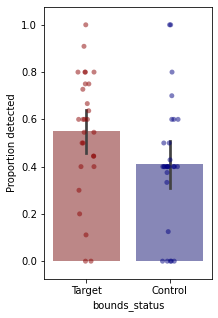

In [27]:
fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((subset_probes_target,subset_probes_control)),
                               'bounds_status':np.hstack((np.zeros(len(subset_probes_target)),
                                                          np.ones(len(subset_probes_control))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
plt.xticks([0,1],['Target','Control'])
plt.ylabel('Proportion detected')
plt.ylim(-0.075,1.075)
print(stats.ttest_rel(subset_probes_target,subset_probes_control,nan_policy='omit'))

fig.savefig('svgs/exp2_spatialprobe/subjectwise_boundary_detection_matched_dist.svg')

In [28]:
# Cohen's D
difference = np.array(subset_probes_target) - np.array(subset_probes_control)
mean_diff = np.nanmean(difference)
sd_diff = np.nanstd(difference)

d = mean_diff/sd_diff
d

0.6276416728851412

17


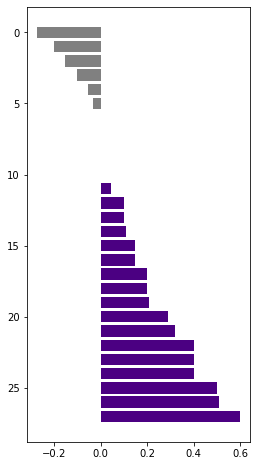

In [34]:
sub_differences=np.array(subset_probes_target)-np.array(subset_probes_control)

neg_vals=np.where(np.sort(sub_differences)<=0)[0]
pos_vals=np.where(np.sort(sub_differences)>0)[0]
colors=np.hstack((np.repeat('grey',len(neg_vals)),np.repeat('indigo',len(pos_vals))))

print(len(pos_vals))
fig,ax=plt.subplots(1,figsize=(4,8))
ax.barh(np.arange(len(sub_differences)),np.sort(sub_differences),color=colors)
ax.invert_yaxis()
fig.savefig('svgs/exp2_spatialprobe/subjectwise_target_detection_differences_matched.svg')

In [35]:
probe_detection_vals=dict()
probe_distance_vals=dict()

for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    for i, probe in enumerate(probe_names):

        try:
            euc_dist=distance_dict[probe.split('.mp4')[0]]
        except:
            euc_dist=np.nan
        
        if probe in probe_detection_vals.keys():
            probe_detection_vals[probe]+=[~np.isnan(reorganized_data_dict[sub]['keypresses'][i])]
        else:
            probe_detection_vals[probe]=[~np.isnan(reorganized_data_dict[sub]['keypresses'][i])]
            probe_distance_vals[probe]=euc_dist 

In [36]:
detection_vals=np.array([np.sum(probe_detection_vals[probe])/len(probe_detection_vals[probe]) 
                for probe in probe_detection_vals.keys()])
probe_status=[probe[-6:-5] for probe in probe_detection_vals.keys()]
print(len(detection_vals))

147


253.45776551404467


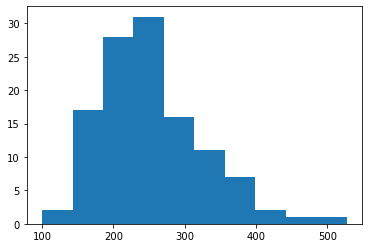

In [37]:
plt.hist(list(probe_distance_vals.values()))
print(np.nanmean(list(probe_distance_vals.values())))

In [38]:
arranged_colors=[]
for i in probe_status:
    if i=='C':
        arranged_colors.append('navy')
    elif i=='T':
        arranged_colors.append('crimson')
    else:
        arranged_colors.append('black')

In [39]:
lower_bound_mask=np.array(list(probe_distance_vals.values()))>225
upper_bound_mask=np.array(list(probe_distance_vals.values()))<275

bounds_mask=lower_bound_mask*upper_bound_mask

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/dev_brainiak/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


116
(-0.1691136908087652, 0.06955777074321805)


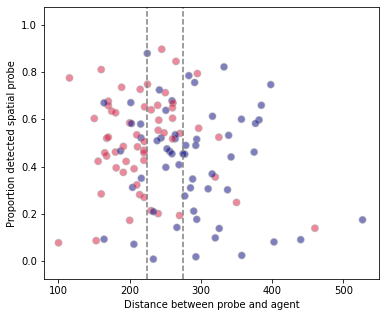

In [40]:
fig=plt.figure(figsize=(6,5))

mask=~np.isnan(list(probe_distance_vals.values()))*~np.isnan(detection_vals) #*bounds_mask

sns.regplot(np.array(list(probe_distance_vals.values()))[mask],detection_vals[mask],fit_reg=False,
            x_jitter=0.025,y_jitter=0.025,scatter_kws={'facecolors':np.array(arranged_colors)[mask],
                                                     'edgecolors':'darkgrey',
                                                     'alpha':0.5,'s':50},
           line_kws={'color':'dimgrey'})

plt.ylim(-0.075,1.075)
plt.xlim(80,550)
plt.xlabel('Distance between probe and agent')
plt.ylabel('Proportion detected spatial probe')

plt.axvline(225,linestyle='dashed',color='grey')
plt.axvline(275,linestyle='dashed',color='grey')

print(len(detection_vals[mask]))
print(stats.pearsonr(np.array(list(probe_distance_vals.values()))[mask],detection_vals[mask],))

fig.savefig('svgs/exp2_spatialprobe/spatialprobe_dist_colored.svg')

### What about the different letter probes? 

In [41]:
all_probes_ekey=[]
all_probes_fkey=[]

num_ekey=[]
num_fkey=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_e=[]
    probes_f=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['key_type'][i]=='E_Key': # if its a probe trial 
            probes_e.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))
        elif reorganized_data_dict[sub]['key_type'][i]=='F_Key':
            probes_f.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))

    print(sub,len(probes_e),len(probes_f))
    num_ekey.append(len(probes_e))
    num_fkey.append(len(probes_f))
    
    all_probes_ekey.append(np.nansum(probes_e)/len(probes_e))
    all_probes_fkey.append(np.nansum(probes_f)/len(probes_f))


debug0iCMg:debugWY61I 26 28
debugBEZtm:debugyuUEV 28 28
debugDHa10:debugW00CK 28 26
debugEKZo6:debugTZHgd 26 27
debugF0Ygs:debugkaQeS 23 28
debugGllfh:debug0IrHv 29 28
debugJ5iCd:debugfh5y4 27 28
debugMh0LT:debugcxEIB 24 27
debugOMHPx:debugk4Hmz 29 29
debugR7K73:debughs4QH 28 29
debugSpTtY:debugElPAb 28 27
debugT1mQA:debugSWcXn 29 27
debugULpzm:debugiI7NU 29 29
debugYi1CF:debugl3qvU 28 27
debuga5s3v:debugMahYT 24 26
debughcTSC:debugGNUKv 28 28
debugkIJMc:debugQSmRA 28 26
debugl1ZJT:debugcAxEj 27 27
debuglOKep:debugscIb2 28 25
debuglYWls:debug9gLtL 24 27
debugmYRmd:debugoGlaW 28 27
debugohwY9:debugGYEP1 27 26
debugpg6Ov:debugVP4xk 27 25
debugtV1Vf:debuggjVYU 28 28
debugv0eK8:debugHQjFF 28 26
debugw1cvt:debuggVhaX 28 29
debugxrt6i:debugZWrJP 27 29
debugyWHpH:debugLKCkP 21 19


Average e key detected: = 0.4091 (N=26.96 average)
Average f key detected: = 0.5038 (N=27.00 average)
Ttest_relResult(statistic=-3.2236750030249977, pvalue=0.003297783473640251)


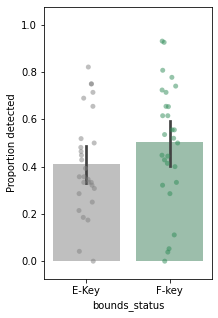

In [42]:
print('Average e key detected: = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_ekey),
                                                             np.nanmean(num_ekey)))
print('Average f key detected: = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_fkey),
                                                                    np.nanmean(num_fkey)))

fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_ekey,all_probes_fkey)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_ekey)),
                                                          np.ones(len(all_probes_fkey))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['grey','seagreen'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['grey','seagreen'],alpha=0.5)
plt.xticks([0,1],['E-Key','F-key'])
plt.ylabel('Proportion detected')
plt.ylim(-0.075,1.075)
print(stats.ttest_rel(all_probes_ekey,all_probes_fkey,nan_policy='omit'))

fig.savefig('svgs/exp2_spatialprobe/subjectwise_key_type_detection.svg')


In [43]:
all_probes_target=[]
all_probes_control=[]

num_target=[]
num_control=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_target=[]
    probes_control=[]
    probes_non_boundaries=[]
    
    for i, probe in enumerate(probe_names):

        
        if reorganized_data_dict[sub]['key_type'][i]=='E_Key':
            if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
                probes_target.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))
            elif reorganized_data_dict[sub]['probe'][i]==2:
                probes_control.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))

    print(sub,len(probes_target),len(probes_control))
    num_target.append(len(probes_target))
    num_control.append(len(probes_control))
    
    all_probes_target.append(np.nansum(probes_target)/len(probes_target))
    all_probes_control.append(np.nansum(probes_control)/len(probes_control))


debug0iCMg:debugWY61I 8 18
debugBEZtm:debugyuUEV 17 11
debugDHa10:debugW00CK 11 17
debugEKZo6:debugTZHgd 9 17
debugF0Ygs:debugkaQeS 13 10
debugGllfh:debug0IrHv 11 18
debugJ5iCd:debugfh5y4 17 10
debugMh0LT:debugcxEIB 9 15
debugOMHPx:debugk4Hmz 11 18
debugR7K73:debughs4QH 10 18
debugSpTtY:debugElPAb 18 10
debugT1mQA:debugSWcXn 18 11
debugULpzm:debugiI7NU 18 11
debugYi1CF:debugl3qvU 10 18
debuga5s3v:debugMahYT 10 14
debughcTSC:debugGNUKv 18 10
debugkIJMc:debugQSmRA 10 18
debugl1ZJT:debugcAxEj 11 16
debuglOKep:debugscIb2 18 10
debuglYWls:debug9gLtL 10 14
debugmYRmd:debugoGlaW 17 11
debugohwY9:debugGYEP1 17 10
debugpg6Ov:debugVP4xk 10 17
debugtV1Vf:debuggjVYU 10 18
debugv0eK8:debugHQjFF 17 11
debugw1cvt:debuggVhaX 11 17
debugxrt6i:debugZWrJP 16 11
debugyWHpH:debugLKCkP 13 8


Average target detected (e key): = 0.4640 (N=13.14 average)
Average control detected (e key): = 0.3595 (N=13.82 average)
Ttest_relResult(statistic=3.195526884183456, pvalue=0.0035389771010776528)


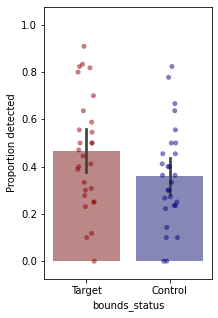

In [44]:
print('Average target detected (e key): = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_target),
                                                             np.nanmean(num_target)))
print('Average control detected (e key): = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_control),
                                                                    np.nanmean(num_control)))

fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_target,all_probes_control)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_target)),
                                                          np.ones(len(all_probes_control))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
plt.xticks([0,1],['Target','Control'])
plt.ylabel('Proportion detected')
plt.ylim(-0.075,1.075)
print(stats.ttest_rel(all_probes_target,all_probes_control,nan_policy='omit'))

fig.savefig('svgs/exp2_spatialprobe/subjectwise_detection_ekey.svg')


In [45]:
all_probes_target=[]
all_probes_control=[]

num_target=[]
num_control=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_target=[]
    probes_control=[]
    probes_non_boundaries=[]
    
    for i, probe in enumerate(probe_names):

        
        if reorganized_data_dict[sub]['key_type'][i]=='F_Key':
            if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
                probes_target.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))
            elif reorganized_data_dict[sub]['probe'][i]==2:
                probes_control.append(~np.isnan(reorganized_data_dict[sub]['keypresses'][i]))

    print(sub,len(probes_target),len(probes_control))
    num_target.append(len(probes_target))
    num_control.append(len(probes_control))
    
    all_probes_target.append(np.nansum(probes_target)/len(probes_target))
    all_probes_control.append(np.nansum(probes_control)/len(probes_control))

debug0iCMg:debugWY61I 15 13
debugBEZtm:debugyuUEV 14 14
debugDHa10:debugW00CK 14 12
debugEKZo6:debugTZHgd 15 12
debugF0Ygs:debugkaQeS 14 14
debugGllfh:debug0IrHv 14 14
debugJ5iCd:debugfh5y4 14 14
debugMh0LT:debugcxEIB 15 12
debugOMHPx:debugk4Hmz 15 14
debugR7K73:debughs4QH 15 14
debugSpTtY:debugElPAb 12 15
debugT1mQA:debugSWcXn 14 13
debugULpzm:debugiI7NU 14 15
debugYi1CF:debugl3qvU 14 13
debuga5s3v:debugMahYT 14 12
debughcTSC:debugGNUKv 14 14
debugkIJMc:debugQSmRA 13 13
debugl1ZJT:debugcAxEj 14 13
debuglOKep:debugscIb2 12 13
debuglYWls:debug9gLtL 14 13
debugmYRmd:debugoGlaW 14 13
debugohwY9:debugGYEP1 13 13
debugpg6Ov:debugVP4xk 14 11
debugtV1Vf:debuggjVYU 14 14
debugv0eK8:debugHQjFF 12 14
debugw1cvt:debuggVhaX 15 14
debugxrt6i:debugZWrJP 14 15
debugyWHpH:debugLKCkP 9 10


Average target detected (f key): = 0.5285 (N=13.75 average)
Average control detected (f key): = 0.4813 (N=13.25 average)
Ttest_relResult(statistic=1.4646979823733652, pvalue=0.15455126097398267)


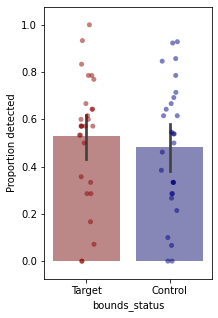

In [46]:
print('Average target detected (f key): = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_target),
                                                             np.nanmean(num_target)))
print('Average control detected (f key): = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_control),
                                                                    np.nanmean(num_control)))

fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_target,all_probes_control)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_target)),
                                                          np.ones(len(all_probes_control))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
plt.xticks([0,1],['Target','Control'])
plt.ylabel('Proportion detected')
plt.ylim(-0.075,1.075)
print(stats.ttest_rel(all_probes_target,all_probes_control,nan_policy='omit'))

fig.savefig('svgs/exp2_spatialprobe/subjectwise_detection_fkey.svg')


### Confidence

In [47]:
all_probes_target_conf=[]
all_probes_control_conf=[]

for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_target_conf=[]
    probes_control_conf=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
            probes_target_conf.append(float(reorganized_data_dict[sub]['confidence'][i]))
        elif reorganized_data_dict[sub]['probe'][i]==2:
            probes_control_conf.append(float(reorganized_data_dict[sub]['confidence'][i]))

            
    all_probes_target_conf.append(np.nanmean(probes_target_conf))
    all_probes_control_conf.append(np.nanmean(probes_control_conf))

In [48]:
print('Average target conf: = %0.4f'%(np.nanmean(all_probes_target_conf)))
print('Average control conf: = %0.4f'%(np.nanmean(all_probes_control_conf)))

Average target conf: = 61.8586
Average control conf: = 57.4671


Ttest_relResult(statistic=3.282867889258997, pvalue=0.002841086563572119)


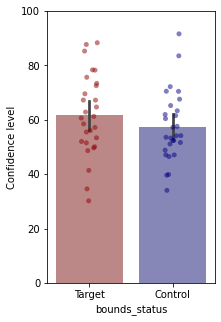

In [49]:
fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_target_conf,all_probes_control_conf)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_target_conf)),
                                                          np.ones(len(all_probes_control_conf))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
plt.xticks([0,1],['Target','Control'])
plt.ylabel('Confidence level')
plt.ylim(0,100)
print(stats.ttest_rel(all_probes_target_conf,all_probes_control_conf,nan_policy='omit'))

fig.savefig('svgs/exp2_spatialprobe/subjectwise_confidence.svg')

### RT Info

In [50]:
all_probes_target_rt=[]
all_probes_control_rt=[]

for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_target_rt=[]
    probes_control_rt=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
            probes_target_rt.append(float(reorganized_data_dict[sub]['rt_correct'][i]))
        elif reorganized_data_dict[sub]['probe'][i]==2:
            probes_control_rt.append(float(reorganized_data_dict[sub]['rt_correct'][i]))

            
    all_probes_target_rt.append(np.nanmean(probes_target_rt))
    all_probes_control_rt.append(np.nanmean(probes_control_rt))

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


In [51]:
print('Average target rt: = %0.4f'%(np.nanmean(all_probes_target_rt)))
print('Average control rt: = %0.4f'%(np.nanmean(all_probes_control_rt)))

Average target rt: = 1603.0742
Average control rt: = 1635.3661


Ttest_relResult(statistic=-1.8345636974945267, pvalue=0.07849886786343163)


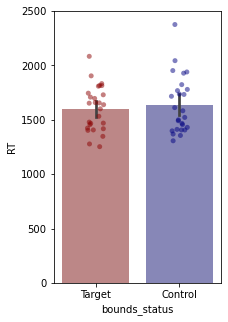

In [52]:
fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_target_rt,all_probes_control_rt)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_target_rt)),
                                                          np.ones(len(all_probes_control_rt))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['darkred','navy'],alpha=0.5)
plt.xticks([0,1],['Target','Control'])
plt.ylabel('RT')
plt.ylim(0,2500)
print(stats.ttest_rel(all_probes_target_rt,all_probes_control_rt,nan_policy='omit'))

fig.savefig('svgs/exp2_spatialprobe/subjectwise_rt.svg')